### Imports

In [1]:
import os
import sys

ROOT = os.path.abspath('/home/jumidlej/git-projects/mdc-melanoma-tbdt/')
sys.path.append(ROOT)

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import yaml
from pytorch_lightning import Trainer

from scripts.utils import setup_reproducibility, shut_down_warnings
from src.data import get_train_val_dataloaders
from src.models.utils import build_model_from_config
from src.training import MelanomaLitModuleGradCAM

setup_reproducibility(seed=27)
shut_down_warnings()

/home/jumidlej/git-projects/mdc-melanoma-tbdt/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 27


### Get model and predict on validation

In [3]:
MODEL_CONFIG_PATH = ROOT + '/configs/pretrained_efficientnet.yaml'
CHECKPOINT_PATH = ROOT + '/saved_ckpt/effnet-combined.ckpt'

print(f"Loading model config from: {MODEL_CONFIG_PATH}")
print(f"Loading model checkpoint from: {CHECKPOINT_PATH}")

Loading model config from: /home/jumidlej/git-projects/mdc-melanoma-tbdt/configs/pretrained_efficientnet.yaml
Loading model checkpoint from: /home/jumidlej/git-projects/mdc-melanoma-tbdt/saved_ckpt/effnet-combined.ckpt


In [4]:
def load_config(path: Path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [5]:
# ----------------------------------------------------
# 1. Load Config & Setup
# ----------------------------------------------------
config_path = Path(MODEL_CONFIG_PATH)
config = load_config(config_path)

training_cfg = config.get("training", {})
data_cfg = config.get("data", {})
model_cfg = config.get("model", {})

aug_cfg_path = None
if aug_cfg_path is not None:
    aug_cfg_path = Path(aug_cfg_path)
    aug_cfg = load_config(aug_cfg_path)
else:
    aug_cfg = {}

# ----------------------------------------------------
# 2. Data
# ----------------------------------------------------
train_loader, val_loader = get_train_val_dataloaders(
    aug_cfg=aug_cfg,
    batch_size=data_cfg.get("batch_size", 256),
    num_workers=data_cfg.get("num_workers", 4),
)

# ----------------------------------------------------
# 3. Model
# ----------------------------------------------------
backbone = build_model_from_config(model_cfg)

# Carregamos os pesos do checkpoint para dentro do LightningModule
print(f"Carregando checkpoint de: {CHECKPOINT_PATH}")

lit_model = MelanomaLitModuleGradCAM.load_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    model=backbone,
    training_cfg=training_cfg, # Passamos a config para manter compatibilidade
    strict=True 
)

lit_model.eval() 

# ----------------------------------------------------
# 4. Predict
# ----------------------------------------------------
trainer = Trainer(
    accelerator="auto",
    devices=1,
    precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
    logger=False
)
val_predictions = trainer.predict(lit_model, val_loader)

all_images = []
all_probs = []
all_labels = []

# Processando os batches retornados
for batch_output in val_predictions:
    images, logits, labels = batch_output["images"], batch_output["logits"], batch_output["labels"]
    probs = torch.sigmoid(logits)

    all_images.append(images.cpu().float().numpy())
    all_probs.append(probs.cpu().float().numpy())
    all_labels.append(labels.cpu().float().numpy())

# Concatenar todos os arrays numpy
all_images = np.concatenate(all_images, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

Carregando checkpoint de: /home/jumidlej/git-projects/mdc-melanoma-tbdt/saved_ckpt/effnet-combined.ckpt


/home/jumidlej/git-projects/mdc-melanoma-tbdt/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:06<00:00,  5.83it/s]


### Denormalize and show image functions

In [6]:
from src.data import IMAGENET_MEAN, IMAGENET_STD

def denormalize_numpy_array(img_numpy):
    img = img_numpy.transpose(1, 2, 0)
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

def denormalize_torch_tensor(img_tensor):
    img = img_tensor.permute(1, 2, 0)
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

In [7]:
import matplotlib.pyplot as plt

def show_images(df_subset, n=6, title=""):
    df_subset = df_subset.sample(n=min(n, len(df_subset)))

    plt.figure(figsize=(3 * n, 3))
    for i, (_, row) in enumerate(df_subset.iterrows()):
        img = row["image"]

        img = denormalize_numpy_array(img)

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"y={row['prob_real']} | "
            f"p={row['prob_predita']:.2f}"
        )

    plt.suptitle(title)
    plt.show()

### Show probabilities

In [8]:
# Tipo de dados
print("Tipo de dados:")
print(type(all_images))
print(type(all_probs))
print(type(all_labels))

Tipo de dados:
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
# garantir que são arrays 1D
all_labels = np.asarray(all_labels).reshape(-1)
all_probs = np.asarray(all_probs).reshape(-1)

df = pd.DataFrame({
    "image": list(all_images),
    "prob_real": all_labels,
    "prob_predita": all_probs
})

print(df.head())

                                               image  prob_real  prob_predita
0  [[[-2.117904, -2.117904, -2.117904, -2.117904,...        0.0  1.457214e-03
1  [[[1.3412963, 1.5125438, 1.5810429, 1.5125438,...        0.0  1.895428e-05
2  [[[-2.1007793, -2.1007793, -2.1007793, -2.1007...        0.0  4.731119e-07
3  [[[1.1015497, 1.1357993, 1.1529241, 1.1529241,...        0.0  2.784729e-04
4  [[[0.57068247, 0.57068247, 0.5878072, 0.622056...        0.0  1.401901e-04


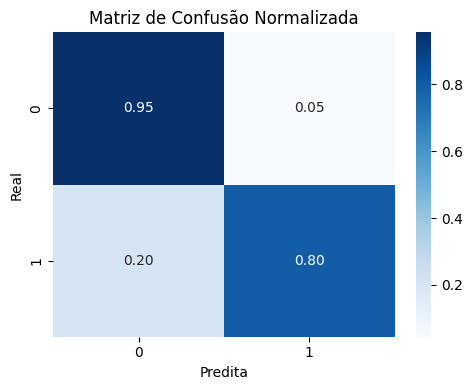

In [10]:
from sklearn.metrics import confusion_matrix

# threshold
threshold = 0.5

y_true = df["prob_real"].values
y_pred = (df["prob_predita"].values >= threshold).astype(int)


cm_norm = confusion_matrix(
    y_true,
    y_pred,
    normalize="true"
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["0", "1"],
    yticklabels=["0", "1"]
)

plt.xlabel("Predita")
plt.ylabel("Real")
plt.title("Matriz de Confusão Normalizada")
plt.tight_layout()
plt.show()


In [11]:
threshold = 0.5

df["pred_label"] = (df["prob_predita"] >= threshold).astype(int)
# confiança = distância ao threshold
df["confidence"] = np.abs(df["prob_predita"] - threshold)

high_conf = 0.4   # bem longe de 0.5
low_conf = 0.1   # perto de 0.5

pos_high = df[
    (df["prob_real"] == 1) &
    # (df["prob_predita"] == 1) &
    (df["confidence"] >= high_conf)
]
neg_high = df[
    (df["prob_real"] == 0) &
    # (df["prob_predita"] == 0) &
    (df["confidence"] >= high_conf)
]
pos_low = df[
    (df["prob_real"] == 1) &
    (df["confidence"] <= low_conf)
]
neg_low = df[
    (df["prob_real"] == 0) &
    (df["confidence"] <= low_conf)
]

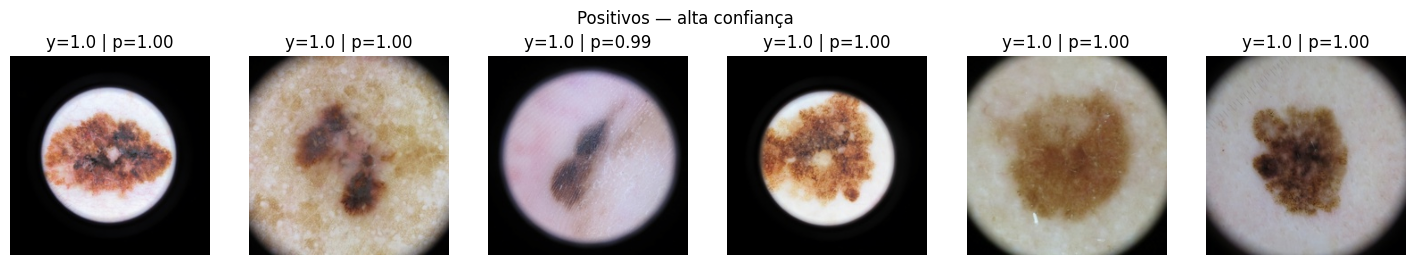

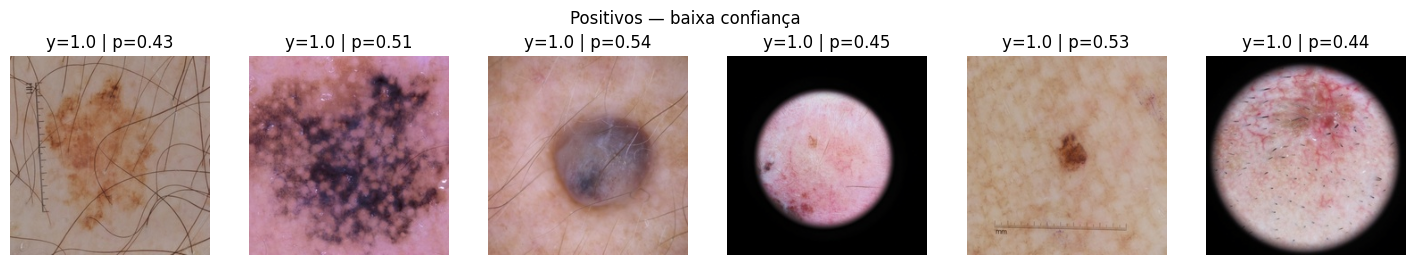

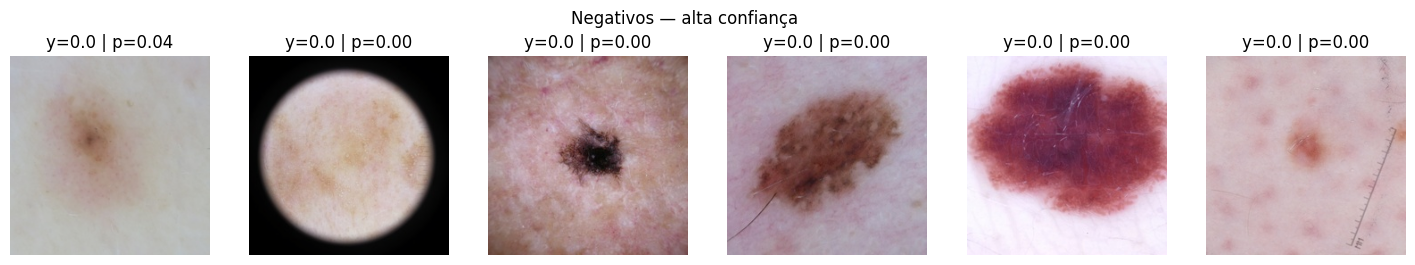

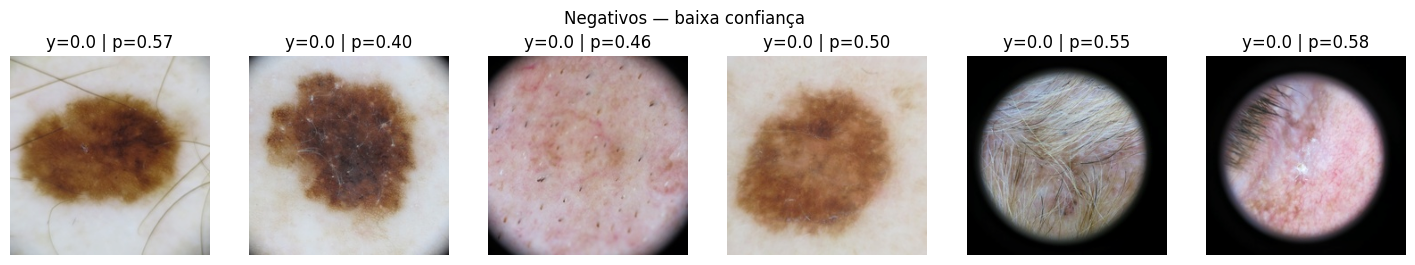

In [12]:
show_images(pos_high, title="Positivos — alta confiança")
show_images(pos_low, title="Positivos — baixa confiança")

show_images(neg_high, title="Negativos — alta confiança")
show_images(neg_low, title="Negativos — baixa confiança")


### Grad-CAM

In [13]:
import torch
import torch.nn.functional as F
import cv2


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handlers = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            def save_gradient(grad):
                self.gradients = grad
            self.handlers.append(output.register_hook(save_gradient))

        self.handlers.append(self.target_layer.register_forward_hook(forward_hook))

    def generate_heatmap(self, input_image, class_idx=None):
        self.model.eval()
        
        # IMPORTANTE: Forçar cálculo de gradiente para o Grad-CAM 
        # mesmo que as camadas estejam congeladas
        with torch.enable_grad():
            # A entrada deve exigir gradiente para o fluxo retroceder
            input_image = input_image.clone().detach().requires_grad_(True)
            
            output = self.model(input_image)

            if class_idx is None:
                # Se for regressão (1 logit), usamos o próprio valor. 
                # Se for classificação, pegamos o índice da maior probabilidade.
                if output.shape[1] == 1:
                    class_loss = output
                else:
                    class_idx = output.argmax(dim=1).item()
                    class_loss = output[0, class_idx]

            self.model.zero_grad()
            class_loss.backward()

            if self.gradients is None:
                raise ValueError("Gradients were not captured. Check target_layer.")

            # Grad-CAM pooling e combinação
            weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
            cam = torch.sum(weights * self.activations, dim=1).squeeze()
            
            cam = F.relu(cam)
            cam = (cam - cam.min()) / (cam.max() + 1e-7)

            return cam.detach().cpu().numpy()

    def remove_hooks(self):
        for h in self.handlers:
            h.remove()


def show_cam_on_image(img: np.ndarray, mask: np.ndarray, use_rgb: bool = True):
    """
    img: Imagem original em formato numpy [H, W, 3] (valores entre 0 e 1)
    mask: O heatmap gerado pelo Grad-CAM [H_small, W_small]
    """
    # 1. Redimensionar o mask para o tamanho da imagem original
    heatmap = cv2.resize(mask, (img.shape[1], img.shape[0]))
    
    # 2. Converter o heatmap para escala de cores (0-255)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 3. Converter de BGR (OpenCV) para RGB se necessário
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)

    # 4. Sobrepor o heatmap na imagem original
    # 0.4 é a opacidade do heatmap, 0.6 a da imagem original
    visualization = heatmap.astype(np.float32) / 255 + img.astype(np.float32)
    visualization = visualization / np.max(visualization)
    
    return np.uint8(255 * visualization)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lit_model.to(device)

# target_layer = lit_model.model.backbone.stages[-1]
target_layer = lit_model.model.backbone.features[-1]

gradcam = GradCAM(lit_model.model, target_layer)

/home/jumidlej/git-projects/mdc-melanoma-tbdt/.venv/lib/python3.13/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_90783/2548428838.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img * IMAGENET_STD + IMAGENET_MEAN


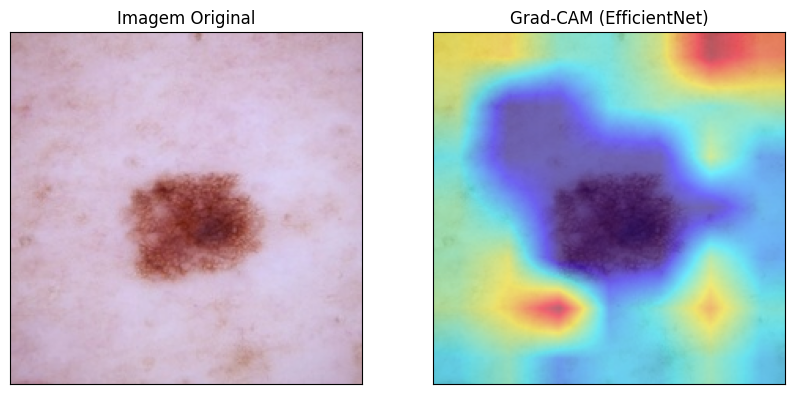

In [15]:
img_tensor, label = val_loader.dataset[6]
x = img_tensor.unsqueeze(0).to(device)

# 1. Gera o mask com a classe GradCAM
heatmap_mask = gradcam.generate_heatmap(x)

img_tensor_denorm = denormalize_torch_tensor(img_tensor)
img_np = np.asarray(img_tensor_denorm)

# 2. Cria a visualização
result = show_cam_on_image(img_np, heatmap_mask)

# 3. Exibe o resultado
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.xticks([]) # Remove os números do eixo X
plt.yticks([]) # Remove os números do eixo Y
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (EfficientNet)")
plt.imshow(result)
plt.xticks([]) # Remove os números do eixo X
plt.yticks([]) # Remove os números do eixo Y
plt.show()

In [16]:
pos_high.iloc[0]

image           [[[0.9988013, 1.0330508, 1.015926, 0.9816765, ...
prob_real                                                     1.0
prob_predita                                             0.005219
pred_label                                                      0
confidence                                               0.494781
Name: 6, dtype: object

/tmp/ipykernel_90783/2548428838.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img * IMAGENET_STD + IMAGENET_MEAN


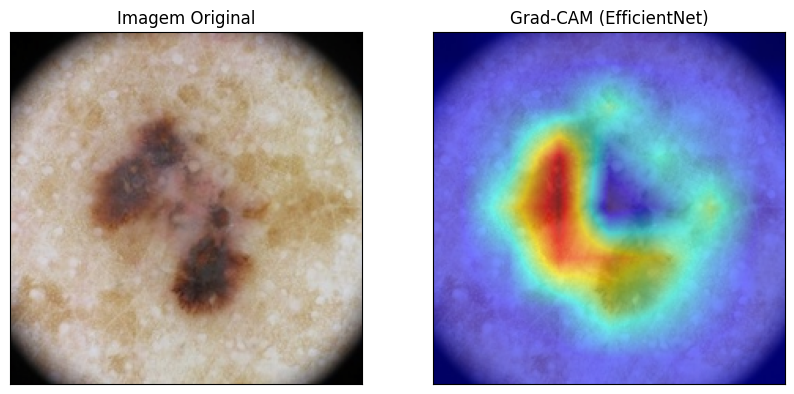

In [17]:
row = pos_high.iloc[3]
img_np_array, label, prob = row["image"], row["prob_real"], row["prob_predita"]
img_tensor = torch.from_numpy(img_np_array)

x = img_tensor.unsqueeze(0).to(device)

# 1. Gera o mask com a classe GradCAM
heatmap_mask = gradcam.generate_heatmap(x)

img_tensor_denorm = denormalize_torch_tensor(img_tensor)
img_np = np.asarray(img_tensor_denorm)

# 2. Cria a visualização
result = show_cam_on_image(img_np, heatmap_mask)

# 3. Exibe o resultado
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.xticks([]) # Remove os números do eixo X
plt.yticks([]) # Remove os números do eixo Y
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (EfficientNet)")
plt.imshow(result)
plt.xticks([]) # Remove os números do eixo X
plt.yticks([]) # Remove os números do eixo Y
plt.show()

In [18]:
def show_images_with_gradcam(
    df_subset,
    gradcam,
    device,
    n=6,
    suptitle=""
):
    df_subset = df_subset.sample(n=min(n, len(df_subset)))

    plt.figure(figsize=(4 * n, 6))

    for i, (_, row) in enumerate(df_subset.iterrows()):
        img_np = row["image"]  # (C, H, W) numpy
        y = row["prob_real"]
        p = row["prob_predita"]

        # numpy → torch
        img_tensor = torch.from_numpy(img_np).float()

        x = img_tensor.unsqueeze(0).to(device)

        # Grad-CAM
        heatmap = gradcam.generate_heatmap(x)

        # imagem original
        img_denorm = denormalize_torch_tensor(img_tensor)
        img_denorm = np.asarray(img_denorm)

        # overlay
        cam_overlay = show_cam_on_image(img_denorm, heatmap)

        # ----- plot -----
        # linha 1: imagem original
        plt.subplot(2, n, i + 1)
        plt.imshow(img_denorm)
        plt.axis("off")
        plt.title(
            f"Original\n"
            f"y={int(y)} | p={p:.2f}",
            fontsize=18
        )

        # linha 2: grad-cam
        plt.subplot(2, n, n + i + 1)
        plt.imshow(cam_overlay)
        plt.axis("off")
        plt.title("Grad-CAM", fontsize=18)

    plt.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_90783/2548428838.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img * IMAGENET_STD + IMAGENET_MEAN


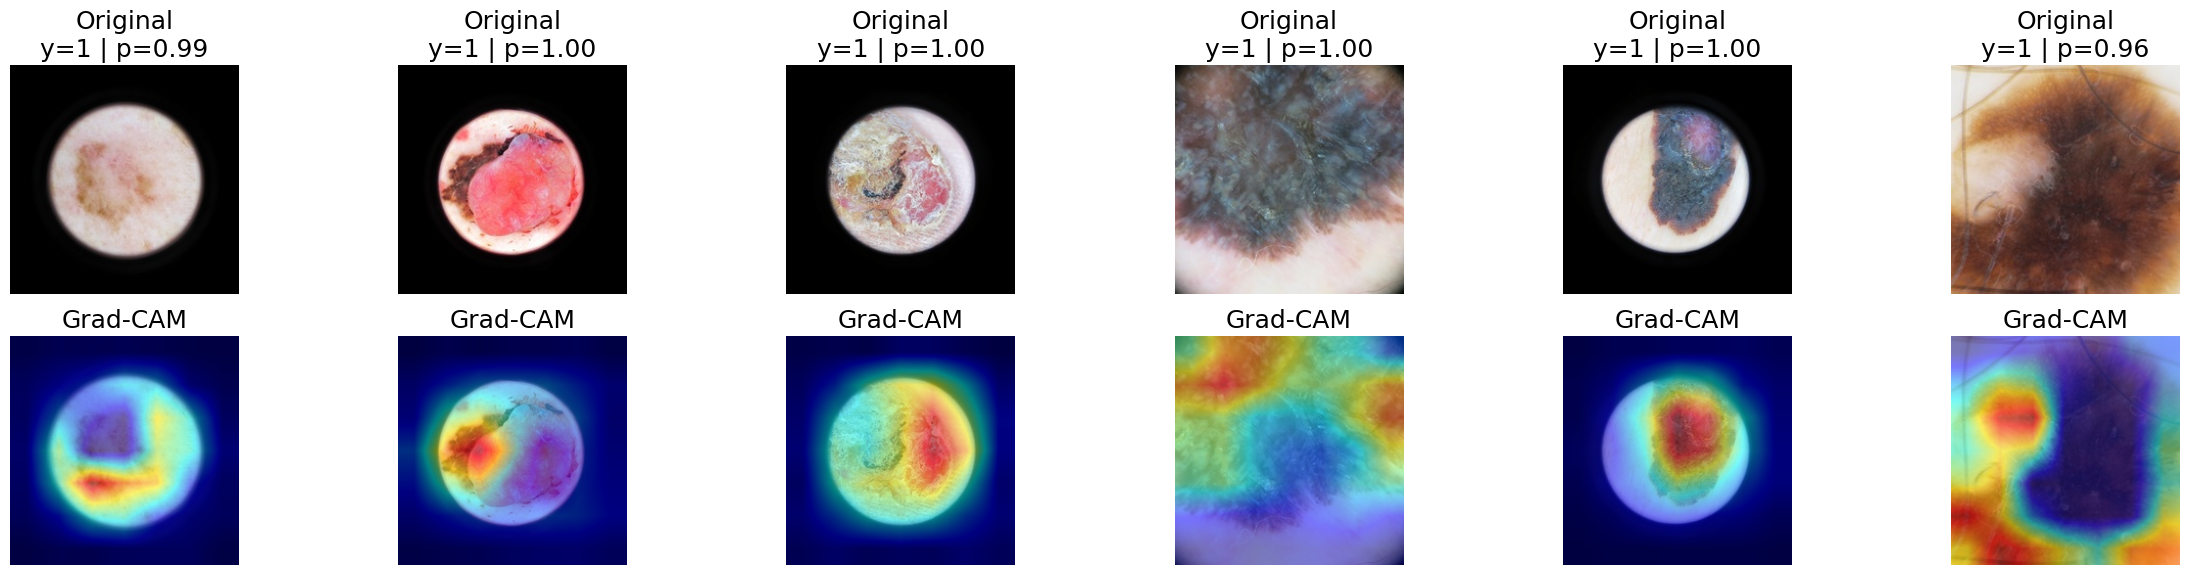

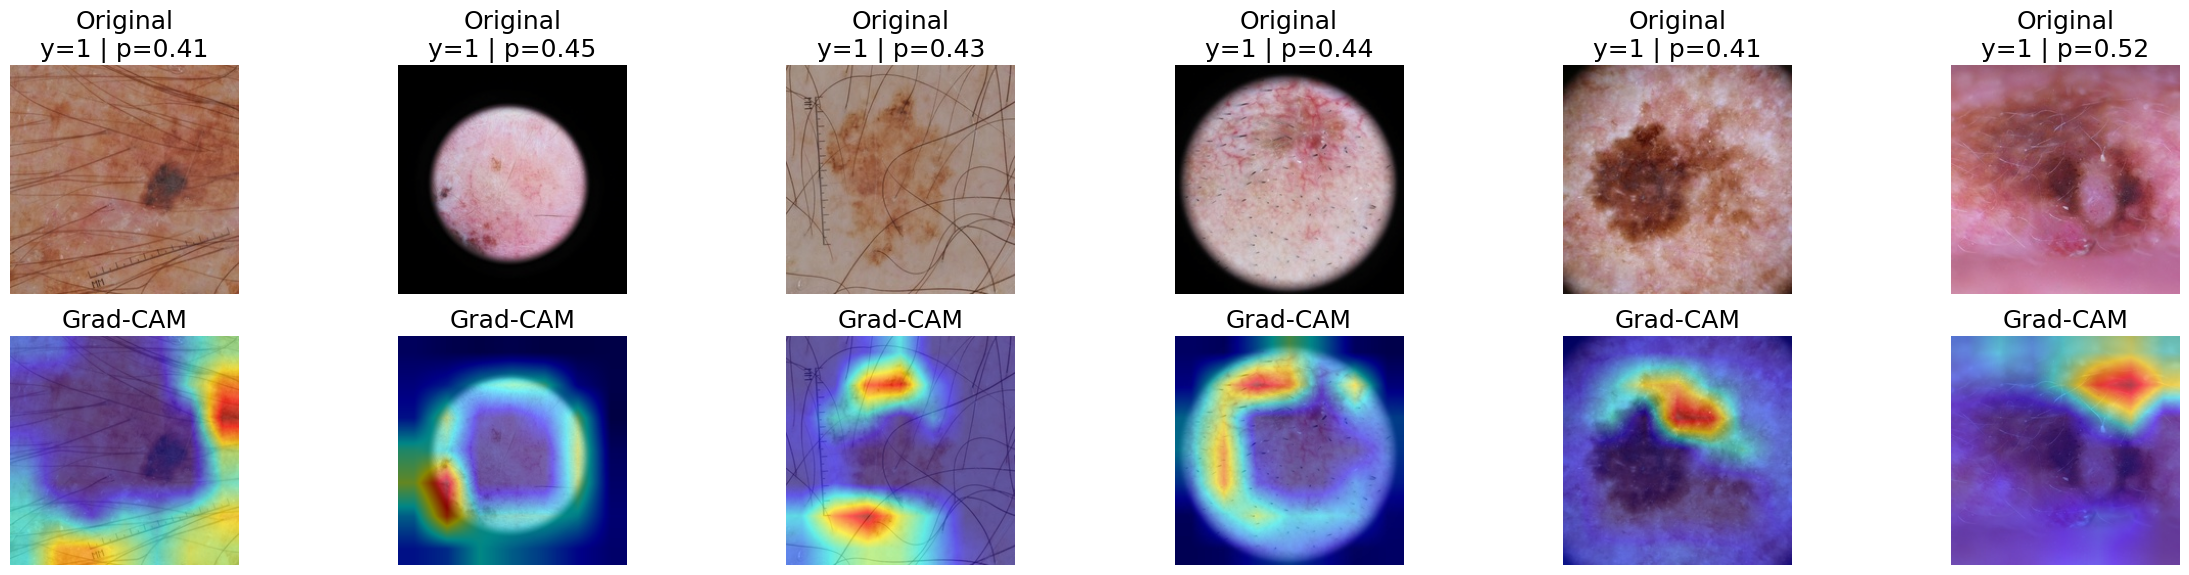

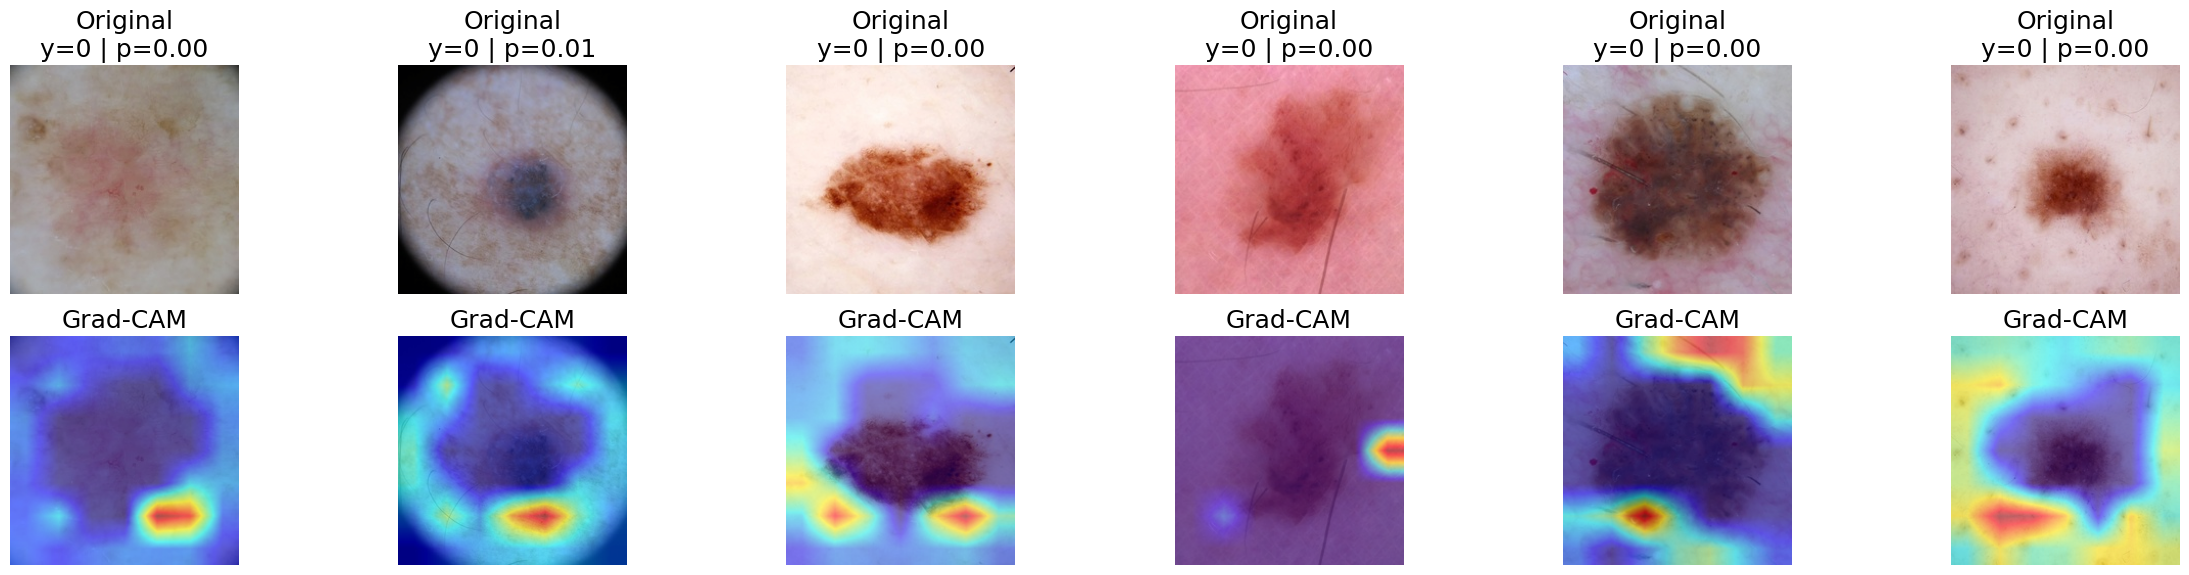

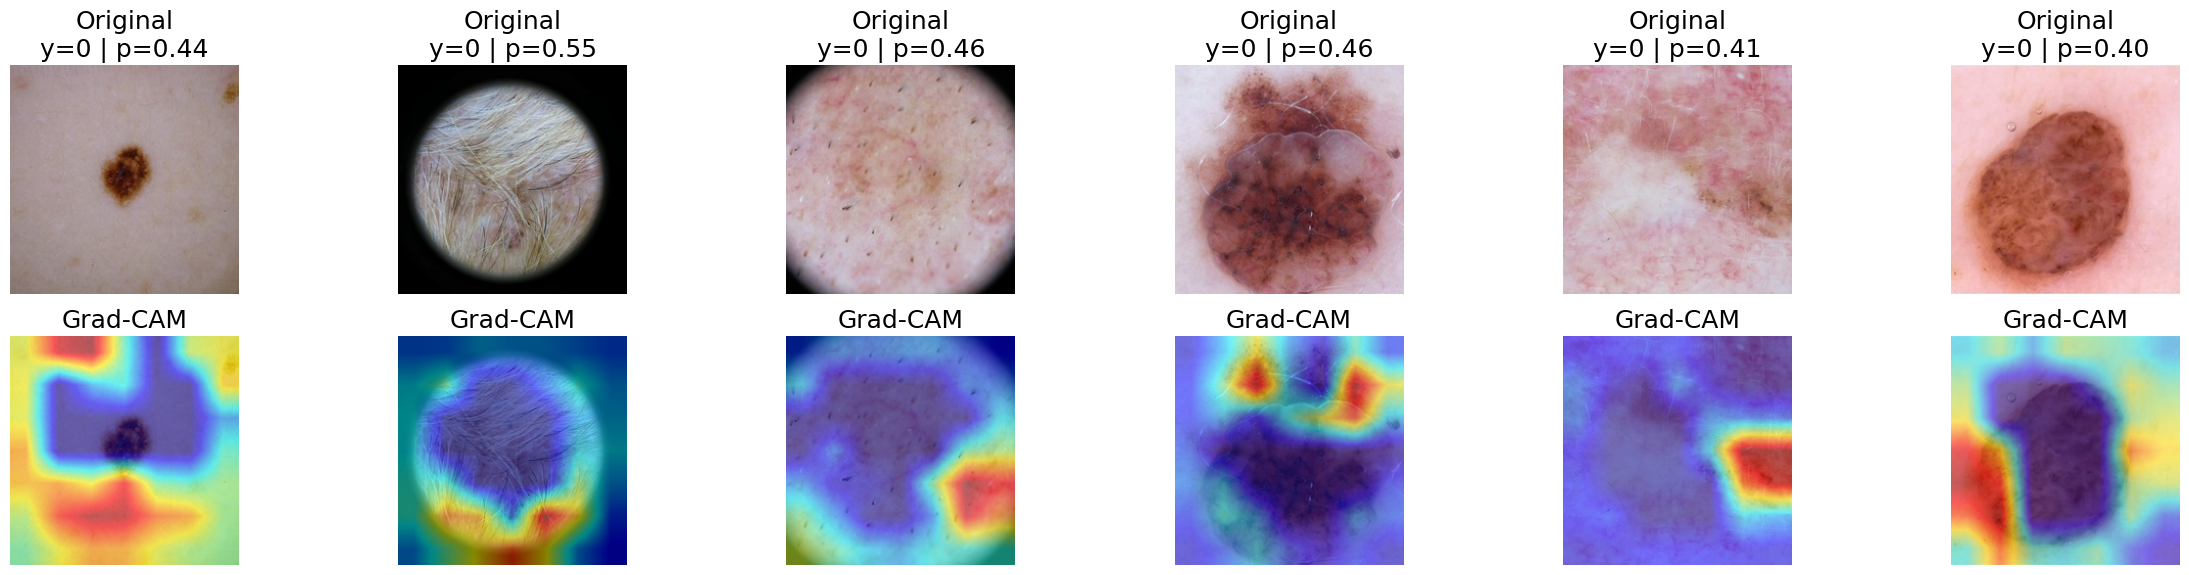

In [19]:
show_images_with_gradcam(pos_high, gradcam=gradcam, device=device)
show_images_with_gradcam(pos_low, gradcam=gradcam, device=device)
show_images_with_gradcam(neg_high, gradcam=gradcam, device=device)
show_images_with_gradcam(neg_low, gradcam=gradcam, device=device)

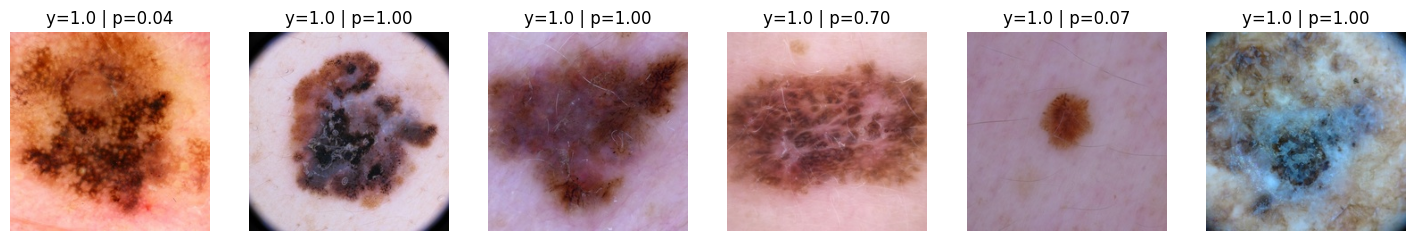

In [20]:
show_images(df[df['prob_real']==1])

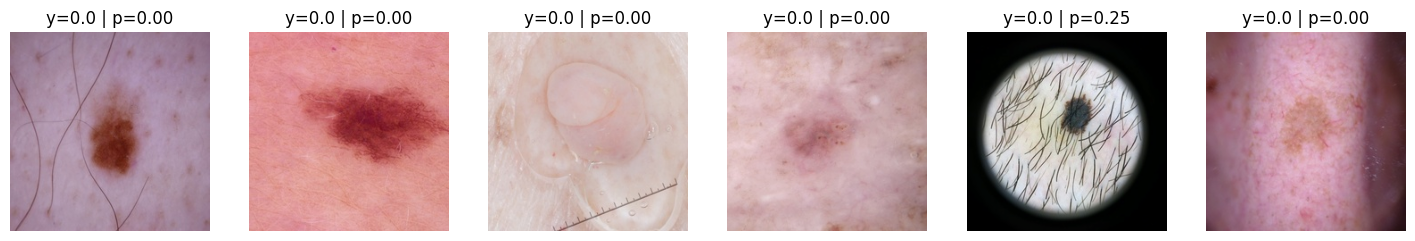

In [21]:
show_images(df[df['prob_real']==0])